# Imports

In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.learner import model_meta
from fastai.callbacks import SaveModelCallback
# from torchvision.models import *  # import *=all the models from torchvision  
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook
import shutil
import joblib
from custom_callbacks_samplers import SamplingCallback, OverSamplingCallback
import pretrainedmodels

from tqdm import tqdm_notebook

# from custom_losses import FocalLoss, AnchorLoss, lovasz_softmax_flat
from custom_callbacks_samplers import SamplingCallback , OverSamplingCallback

loss_dict = {
        "cross_entropy": CrossEntropyFlat(),
        # "focal_loss": FocalLoss(),
        # "anchor_loss": AnchorLoss(),
        # "lovasz_softmax": lovasz_softmax_flat,
    }

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Config

In [2]:
CWD = Path.cwd()

root_path = CWD / 'covid_dataset'
train_path = root_path / "train"
test_path = root_path / "test"
model_save_dir = 'models'
WAND_LOGGING = True
if WAND_LOGGING:
    import wandb
    from wandb.fastai import WandbCallback
#     "hacker_earth_gala_individual"

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
config = dict()

config['arch'] = "xception"
config['pretrained'] = True
config['batch_size'] = 32
config['image_size'] = 224
config['transforms'] = dict(do_flip=True, 
                      flip_vert=False,
                      max_rotate=10.0, 
                      max_zoom=1.1, 
                      max_lighting=0.2, 
                      max_warp=0.2, 
                      p_affine=0.75, 
                      p_lighting=0.75)
config['extra_transforms'] = [cutout(n_holes=(1,4), length=(20, 50), p=.5)]
config['mixup'] = True
config['augmix'] = False
config['cutmix'] = False
config['mixed_precision'] = False
config['learning_rate'] = 1e-2
config['weight_decay'] = 1e-2
config['dropout'] = 0.2
config['loss'] = "cross_entropy"
if WAND_LOGGING:
    config['wandb_callbacks'] = partial(WandbCallback,save_model=False, mode='max', monitor='f_beta', log='all', input_type='images')
config['oversampling'] = False
config['stratified_sampling'] = False

def get_model_str():
    loss_str = config["loss"]
    model_str = config["arch"]
    model_tag = "{}_{}_fastai".format(model_str, loss_str)
    if config['mixup']:
        model_tag = model_tag+"_mixup"
    if config['augmix']:
        model_tag = model_tag+"_augmix"
    if config['cutmix']:
        model_tag = model_tag+"_cutmix"
    if config['oversampling']:
        model_tag = model_tag+"_oversampling"
    if config['stratified_sampling']:
        model_tag = model_tag+"_stratified_sampling"
    return model_tag

model_tag = get_model_str()
config["model_str"] = model_tag
print("Experiment tag: {}".format(config["model_str"]))
if WAND_LOGGING:
    config['project_name'] = 'Covid_xray'
#     wandb.init(project="hacker_earth_gala", name=model_tag, config=config)

Experiment tag: xception_cross_entropy_fastai_mixup


# Setup

In [5]:
train = pd.read_csv(root_path/"train_split.txt", sep=' ', header=None, names=['id','Image','Class']).drop('id',axis=1)
test = pd.read_csv(root_path/"test_split.txt", sep=' ', header=None, names=['id','Image','Class']).drop('id',axis=1)
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=42)
train_idx, val_idx = next(cv.split(train['Image'],train['Class']))

data = None
def get_data_bunch(n_workers=4, reload=False):
    global data
    if reload:
        data = None
    tfms_args = config['transforms']
    tfms_args['xtra_tfms'] = config['extra_transforms']
    tfms = get_transforms(**tfms_args)
    if data is None:
        data = (ImageList.from_df(train, path = train_path)
        #         .split_by_rand_pct(0.1)
                .split_by_idxs(train_idx.tolist(), val_idx.tolist())
                .label_from_df(cols=['Class'])
                .transform(tfms=tfms, size=config['image_size']) 
                # We have our custom transformations implemented in the image loader but we could apply transformations also here
                # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
        #         .normalize()
               .add_test(ImageList.from_df(test, path=test_path))
                .databunch(bs=config['batch_size'], num_workers = n_workers)
                .normalize()
               )
    return data

# "pretrained" is hardcoded to adapt to the PyTorch model function
def xception(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.xception(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))


model_meta[xception] = { 'cut': -1, 'split': lambda m: (m[0][11], m[1]) }

def get_callback_fns(wandb_flag,save_callback_flag):
    callback_fns = [ShowGraph]
    if save_callback_flag:
        callback_fns.append(partial(SaveModelCallback,monitor='f_beta', mode='max', every='improvement', name=config['model_str']+"_best_model"))
    if config['oversampling']:
        callback_fns.append(partial(OverSamplingCallback))
    if config['stratified_sampling']:
        callback_fns.append(partial(Sampling_call_back,weights,len(data.train_dl)))
    if WAND_LOGGING:
        if wandb_flag:
            callback_fns.append(config['wandb_callbacks'])
    return callback_fns

def getLearner(wandb_flag=True, reload_data=False, saved_file=None, save_callback_flag=True):
    data = get_data_bunch(reload=reload_data)
    callback_fns = get_callback_fns(wandb_flag, save_callback_flag)
    callbacks = []
    f1_score = FBeta(beta=1, average="weighted")
    learner = cnn_learner(data, xception, 
                         pretrained=config['pretrained'], 
                         path='.', 
                         metrics=[accuracy,f1_score], 
                         ps=config['dropout'], 
                         callback_fns=callback_fns,
                        loss_func = loss_dict[config['loss']])
    if saved_file is not None:
        learner.load(saved_file)
        # learner.callback_fns = callback_fns
        if reload_data:
            learner.data = data
            
    if config['mixup']:
        learner.mixup()
    if config['mixed_precision']:
        learner.to_fp16()
    return learner


# Training

## LR Find

In [37]:
learner = getLearner(wandb_flag=False, reload_data=False, saved_file=None, save_callback_flag=False)
# We can use lr_find with different weight decays and record all losses so that we can plot them on the same graph
# Number of iterations is by default 100, but at this low number of itrations, there might be too much variance
# from random sampling that makes it difficult to compare WD's. I recommend using an iteration count of at least 300 for more consistent results.
lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner(wandb_flag=False, reload_data=False, saved_file=None, save_callback_flag=False) #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner(wandb_flag=False, reload_data=False, saved_file=None, save_callback_flag=False) #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
# learner = getLearner(wandb_flag=False) #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


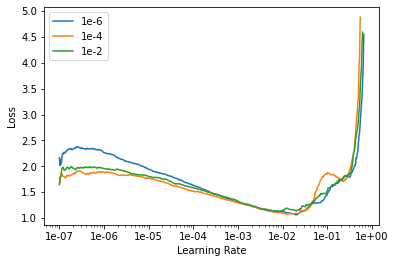

In [38]:
%matplotlib inline
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.5
max_y = 0.55
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
# ax.set_xlim((1e-3,1e-1))
# ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

## Pretrained Training

In [39]:
config['learning_rate'] = max_lr = 5e-3
config['weight_decay'] = wd = 1e-4
if WAND_LOGGING:
    run_obj = wandb.init(project=config['project_name'], name = model_tag, config=config)
run_id = run_obj.get_url().split("/")[-1]
root_dir = os.path.split(run_obj.description_path)[0]

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.122912,0.711178,0.740113,0.715216,01:44
1,0.969316,0.711674,0.687382,0.674118,01:39
2,0.948754,0.777177,0.674200,0.602932,01:40
3,0.903241,0.657446,0.764595,0.759553,01:39
4,0.821439,0.689142,0.755179,0.746351,01:39
5,0.742287,0.536078,0.813559,0.803031,01:39
6,0.734468,0.515198,0.781544,0.763309,01:38
7,0.702168,0.477589,0.804143,0.797887,01:34
8,0.674254,0.482279,0.802260,0.795381,01:41
9,0.680330,0.482930,0.800377,0.792986,01:41


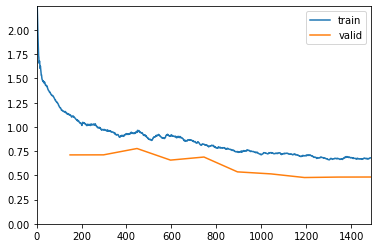

Better model found at epoch 0 with f_beta value: 0.7152157425880432.
Better model found at epoch 3 with f_beta value: 0.7595533132553101.
Better model found at epoch 5 with f_beta value: 0.8030309081077576.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.716383,0.494490,0.794727,0.782295,01:43
1,0.739598,0.563373,0.768362,0.762646,01:41
2,0.749113,1.657985,0.581921,0.545659,01:41
3,0.725745,0.539533,0.777778,0.770134,01:39
4,0.682195,0.512542,0.775895,0.773961,01:29
5,0.684712,0.466578,0.802260,0.785501,01:41
6,0.662819,0.455419,0.817326,0.810853,01:41
7,0.657052,0.439196,0.806026,0.795059,01:42
8,0.640217,0.443034,0.815443,0.807478,01:43
9,0.629037,0.435863,0.832392,0.827010,01:43


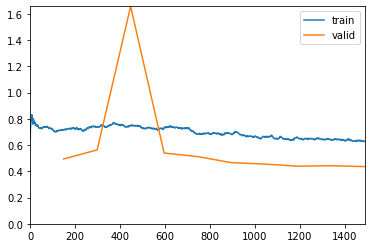

Better model found at epoch 0 with f_beta value: 0.7822949290275574.
Better model found at epoch 5 with f_beta value: 0.7855008244514465.
Better model found at epoch 6 with f_beta value: 0.810853123664856.
Better model found at epoch 9 with f_beta value: 0.8270102143287659.


In [40]:
learner = getLearner(wandb_flag=True, reload_data=False, saved_file=None) #reset learner
# 1cycle policy
learner.fit_one_cycle(cyc_len=10, max_lr=max_lr, wd=wd)
learner.load(config['model_str']+"_best_model")
learner.save("_stage1")
learner.fit_one_cycle(cyc_len=10, max_lr=max_lr, wd=wd)
learner.load(config['model_str']+"_best_model")
learner.save("_stage2")

In [41]:
learner.load("_stage2")
learner.save(config['model_str']+"_{}".format("stage_1"))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.617257,0.438136,0.824859,0.820390,01:45
1,0.643374,0.484572,0.790960,0.785846,01:42
2,0.701408,0.481175,0.789077,0.781169,01:41
3,0.651006,0.490399,0.807910,0.808843,01:42
4,0.656442,0.455634,0.800377,0.783365,01:41
5,0.643660,0.408555,0.824859,0.816273,01:42
6,0.616830,0.401197,0.836158,0.828522,01:42
7,0.608375,0.410516,0.830508,0.825816,01:42
8,0.606780,0.415894,0.836158,0.830636,01:40
9,0.600844,0.410665,0.836158,0.829419,01:41


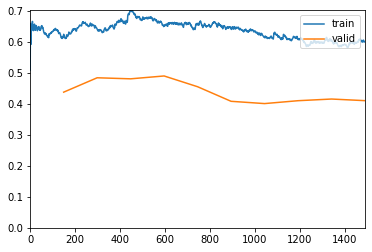

Better model found at epoch 0 with f_beta value: 0.8203895688056946.
Better model found at epoch 6 with f_beta value: 0.8285220861434937.
Better model found at epoch 8 with f_beta value: 0.8306357860565186.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.607597,0.404781,0.841808,0.835668,01:41
1,0.597294,0.416027,0.836158,0.831820,01:46
2,0.604499,0.422156,0.824859,0.820160,01:45
3,0.599996,0.397269,0.841808,0.836675,01:46
4,0.608115,0.404191,0.838041,0.831213,01:47
5,0.602037,0.402044,0.838041,0.832467,01:47
6,0.599638,0.427201,0.824859,0.821717,01:32
7,0.608629,0.397840,0.838041,0.833425,01:24
8,0.598860,0.400095,0.838041,0.831599,01:23
9,0.590845,0.416291,0.834275,0.827030,01:29


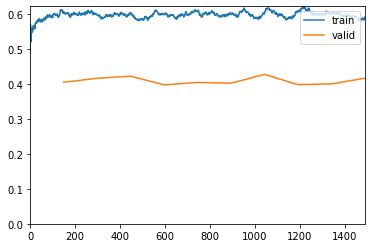

Better model found at epoch 0 with f_beta value: 0.8356684446334839.
Better model found at epoch 3 with f_beta value: 0.8366752862930298.


In [42]:
learner.fit_one_cycle(cyc_len=10, max_lr=max_lr, wd=wd)
learner.load(config['model_str']+"_best_model")
learner.save("_stage3")
config['learning_rate'] = max_lr = 1e-4
learner.fit_one_cycle(cyc_len=10, max_lr=max_lr, wd=wd)
learner.load(config['model_str']+"_best_model")
learner.save("_stage4")

In [43]:
learner.load("_stage4")
learner.save(config['model_str']+"_{}".format("stage_1"))

In [44]:
wandb.join()

In [15]:
learner = getLearner(wandb_flag=True, reload_data=False, saved_file=config['model_str']+"_stage_1")

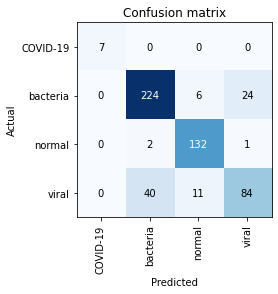

In [45]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

# Finetuning

In [46]:
# config['mixup'] = True
model_str = get_model_str()
config['model_str'] = model_str
finetune_run_name = config['model_str'] + "_finetune"

if WAND_LOGGING:
    finetune_run = wandb.init(project=config['project_name'], name = finetune_run_name, config=config)

## LR Find

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


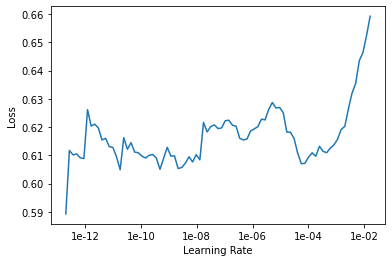

In [47]:
# load the baseline model
learner = getLearner(wandb_flag=False, reload_data=True, saved_file=config['model_str']+"_stage_1", save_callback_flag=False)

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=config['weight_decay'] ,start_lr = 1e-14, end_lr = 1e-1)

# plot learning rate finder results
learner.recorder.plot()

## Training

In [48]:
learner = getLearner(reload_data=False, saved_file=config['model_str']+"_stage_1")
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.597074,0.411306,0.836158,0.828776,01:25
1,0.610296,0.398557,0.841808,0.835222,01:23
2,0.599116,0.418428,0.836158,0.832459,01:23
3,0.591841,0.418524,0.834275,0.828173,01:24
4,0.585037,0.414427,0.832392,0.823690,01:22
5,0.591018,0.412459,0.838041,0.833901,01:20
6,0.609788,0.414781,0.832392,0.825979,01:18
7,0.592758,0.419851,0.832392,0.829607,01:18
8,0.588449,0.407974,0.836158,0.830836,01:21
9,0.606090,0.403532,0.836158,0.831870,01:19


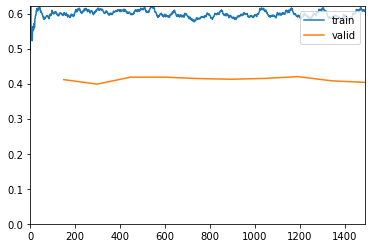

Better model found at epoch 0 with f_beta value: 0.8287761211395264.
Better model found at epoch 1 with f_beta value: 0.835222065448761.


In [49]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle for discriminative LRs
learner.fit_one_cycle(cyc_len=10, max_lr=slice(1e-12,1e-8))
learner.load(config['model_str']+"_best_model")
learner.save("_stage1")

In [50]:
learner.load("_stage1")
learner.save(config['model_str']+"_{}".format("ft_stage_1"))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.608364,0.409858,0.834275,0.826901,01:22
1,0.601607,0.404201,0.839925,0.836257,01:20
2,0.594712,0.410213,0.836158,0.830836,01:20
3,0.591783,0.407474,0.839925,0.833631,01:19
4,0.599200,0.406902,0.845574,0.842041,01:18
5,0.598553,0.412124,0.838041,0.832420,01:19
6,0.596915,0.410146,0.832392,0.827583,01:19
7,0.626044,0.407707,0.834275,0.828557,01:20
8,0.595621,0.405480,0.838041,0.833755,01:20
9,0.584301,0.412344,0.830508,0.824612,01:20


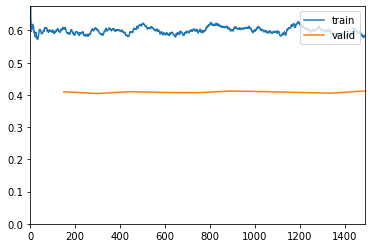

Better model found at epoch 0 with f_beta value: 0.8269009590148926.
Better model found at epoch 1 with f_beta value: 0.8362573385238647.
Better model found at epoch 4 with f_beta value: 0.8420405387878418.


In [55]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle for discriminative LRs
learner.fit_one_cycle(cyc_len=10, max_lr=slice(1e-8,1e-4))
learner.load(config['model_str']+"_best_model")
learner.save("_stage2")

In [57]:
learner.save("_stage2")

In [58]:
learner.load("_stage2")
learner.save(config['model_str']+"_{}".format("ft_stage_1"))

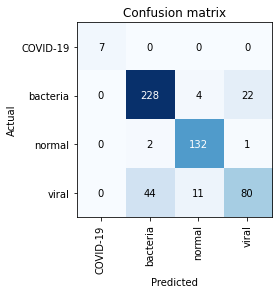

In [51]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')